In order to retrieve the dataset, we first need to install `energyflow` and add the installation directory to our paths.

In [ ]:
!pip install energyflow

In [2]:
import sys
import site
sys.path.append(site.getusersitepackages())

Now we can import everything we need.

In [1]:
import numpy as np
import energyflow as ef
import ROOT

Welcome to JupyROOT 6.30/04


# [RooUnfold](https://gitlab.cern.ch/RooUnfold/RooUnfold) Background

## 1. Overview

![RooUnfoldExplained.jpg](RooUnfoldExplained.jpg)

## 1.Terms and Notation Used:

### Mathematical Problem

A histogram of some distribution $y$ has $M$ bins. $\widehat \mu$ represents the ezpection value of the number of entries in bin $i$ of the histogram. So it progresses for the *true* histogram; $\mu_\mathrm{Tot}=\sum_i\mu_i$ and $p(y|i)=p_i=\mu_i/\mu_\mathrm{Tot}$ The goal of this problem is not to estimate the parameters $\theta$ that parametrise $f(y;\theta)$ but instead the $\mu_i$ parameters for each bin $\overline{\mu}=(\mu_1,...,\mu_M)$. This is not trivial because of fluctuations caused by the act of the measurement itself. Each observation is characterised by a unknown underlying value which is our function $y$ which we are interested in and a measured value $x$ obtained by the experiment.

$$
f(x)_\mathrm{meas}=\int R(x|y)f_\mathrm{true}(y)dy
$$

Where $R(x|y)$ is the response function if $x$ and $y$ are the pdfs represented by histograms.

### Working with Histograms

At this point we should also change from our $f_\mathrm{meas}(x)$ to a notation more suitable to histograms. 

$$
f(x)_\mathrm{meas}=\int R(x|y)f_\mathrm{true}(y)dy
$$

becomes

$$
\nu_i=\sum_{j=1}^M R_{ij}\mu_j,\ \ \ \ \ i= 1,...,N
$$

Where $\mu$ is once again the expectation values for the histogram of $y$ and $\nu$ is the expected number of events in the bins of the observed variable $x$. 
**note**. True data will be an actual event count in each bin and therefore integer values whereas $\nu$ is typically non-integer values. 

We can understand the response matrix as the conditional probability. By summing over the observed data we get the efficiency $\epsilon_j$ for each bin of the true histogram.

We now have several ingreedients; $\nu,\mu$ and $R$. Since the data is a collection of integers $\mathbf{n}$ we can express the above equation as not only the expectation value per bin given the data but also to include the expected number of background events in that bin $\beta_i$. 

$$
E[\mathbf{n}]=\nu=R\mu+\beta
$$

### Unfolding? What's that?
By unfolding we construct estimators  $\widehat{\mu}$ for the bins of $y$ This is useful to directly compared with the results of other experiments as well as with theoretical predictions.

If our goal is generally $\mu$ then we need to invert our response matrix. 
$$
\boldsymbol{\mu}= R^{-1}(\boldsymbol{\nu}-\beta)
$$
We can assume the data is independent (individual events) and therefore each bin can be assumed to follow a poisson distribution.

$$
P(n_i;\nu_i)=\frac{\nu_u^{n_i}}{n_i\!}\exp^{-\nu_i}
$$

The maximum likelihood estimators for $\nu$ are $\mathbf{n}$ and thus can be taken as estimators for $\mu$,

$$
\boldsymbol{\widehat{\mu}}=R^{-1}(\mathbf{n}-\beta)
$$

In a perfect (exact) world all of the elements of the response matrix should be on the diagonal as large, off-diagonal elements indicate that the bin size is too small compared to the measurement resolution, then the estimates of $\ \boldsymbol{\widehat{\mu}}$ will have prohibatively large variances and will have strong negative correlations between neighbouring bins. It can be [proved](http://www.ippp.dur.ac.uk/Workshops/02/statistics/proceedings/cowan.ps) that for independent poisson variables ML estimators in this case are unbiased. By calculating the minimum variance bound in this (unbiased) case we can assume that any estimators that we can construct that have a smaller variance will be biased in some way. This method can be understood as mittigating the effects of a large statistical error in favour of a smaller systematic error.

## Problem Definition:

First let's get some data.

### Omnifold Example Data: Z+Jet Pythia and Herwig w/ Delphes

`gen` is particle level simulation, and `sim` is detector level simulation

We (arbitrarily) choose Pythia to be our simulation, and `Herwig` to be our "data"

In [2]:
N_Events = 10**5

In [3]:
pythia = ef.zjets_delphes.load('Pythia26', num_data=N_Events) # our sythetic sim
herwig = ef.zjets_delphes.load('Herwig', num_data=N_Events)   # our 'data' sim

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
print(list(pythia.keys()))
print(np.shape(pythia['gen_jets']),"\n")

print(list(herwig.keys()))
print(np.shape(herwig['sim_jets']),"\n")

['gen_zgs', 'gen_tau2s', 'gen_Zs', 'gen_sdms', 'gen_widths', 'gen_lhas', 'gen_ang2s', 'gen_mults', 'gen_jets', 'gen_particles', 'sim_zgs', 'sim_tau2s', 'sim_sdms', 'sim_widths', 'sim_lhas', 'sim_ang2s', 'sim_mults', 'sim_jets', 'sim_particles']
(100000, 4) 

['gen_zgs', 'gen_tau2s', 'gen_Zs', 'gen_sdms', 'gen_widths', 'gen_lhas', 'gen_ang2s', 'gen_mults', 'gen_jets', 'gen_particles', 'sim_zgs', 'sim_tau2s', 'sim_sdms', 'sim_widths', 'sim_lhas', 'sim_ang2s', 'sim_mults', 'sim_jets', 'sim_particles']
(100000, 4) 



- `jets` - The jet axis four vector, as ($p_\mathrm{Tjet}$, $y_\mathrm{jet}$, $\phi_\mathrm{jet}$, $m_\mathrm{jet}$)

- `particles` - The rescaled jet constituents ($p_\mathrm{T}$/100,$y−y_\mathrm{jet}$,$\phi−\phi_\mathrm{jet}$, fPID)

- `mults` - The constituent multiplicity of the jet.
- `lhas` - The Les Houches (β=1/2) angularity.
- `widths` - The jet width (β=1 angularity).
- `ang2s` - The β=2 angularity (note that this is very similar to the jet mass, but does not depend on particle masses).
- `tau2s` - The 2-subjettiness with β=1.
- `sdms` - The groomed mass with Soft Drop parameters zcut=0.1 and β=0.
- `zgs` - The groomed momentum fraction (same Soft Drop parameters as above).

In [5]:
# retrieve the jet masses
reco_jets = pythia['sim_jets'][:,3]
truth_jets = pythia['gen_jets'][:,3]
data_jets = herwig['sim_jets'][:,3]
target_jets = herwig['gen_jets'][:,3]
binning = np.logspace(1,2,31)

## Plot the distributions before Unfolding

In [6]:
# define our histograms as normal. 
n_bins = 30
binning = np.logspace(1,2,n_bins+1)
responseHist = ROOT.TH2F("response_hist","response_hist",n_bins,binning,n_bins,binning)
truthHist = ROOT.TH1F("truth","truth",n_bins,binning)
recoHist = ROOT.TH1F("reco","reco",n_bins,binning)
targetHist = ROOT.TH1F("target","target",n_bins,binning)
dataHist = ROOT.TH1F("data","data",n_bins,binning)

In [7]:
for t,r,d,a in zip(truth_jets,reco_jets,data_jets,target_jets):
    truthHist.Fill(t)
    recoHist.Fill(r)
    responseHist.Fill(r,t)
    dataHist.Fill(d,1.001)
    targetHist.Fill(a)

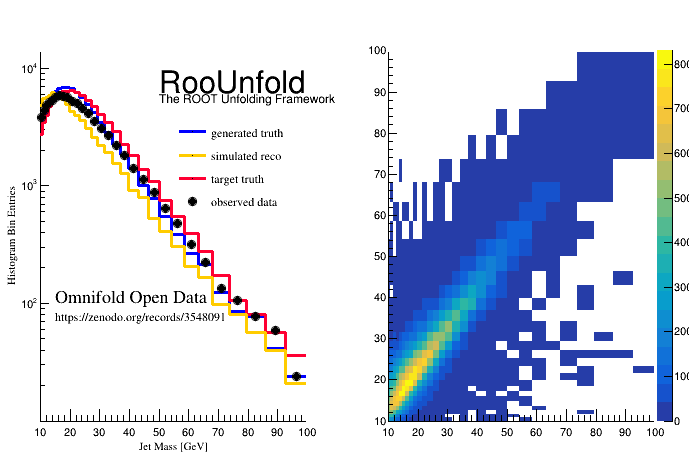

In [8]:
c1 = ROOT.TCanvas()
c1.Divide(2,1)
c1.cd(1)
recoHist.SetLineColor(ROOT.kOrange)
recoHist.SetLineWidth(3)
truthHist.SetLineColor(ROOT.kBlue)
truthHist.SetLineWidth(3)
targetHist.SetLineColor(ROOT.kPink)
targetHist.SetLineWidth(3)
dataHist.SetMarkerStyle(20)
dataHist.SetLineWidth(0)

truthHist.SetStats(0)
truthHist.SetTitle("")
truthHist.Draw()
targetHist.Draw("same")
recoHist.Draw("same")
dataHist.Draw("Hsame")

legend = ROOT.TLegend(.5,.55,.95,.75)
legend.AddEntry(truthHist,"generated truth")
legend.AddEntry(recoHist,"simulated reco")
legend.AddEntry(targetHist,"target truth")
legend.AddEntry(dataHist,"observed data")
legend.SetBorderSize(0)
legend.SetTextFont(132)
legend.SetTextSize(.04)
legend.Draw()

yaxis = truthHist.GetYaxis()
yaxis.SetRangeUser(10,14000)
yaxis.SetTitle("Histogram Bin Entries")
yaxis.SetTitleOffset(1.5)
yaxis.CenterTitle(True)
yaxis.SetTitleFont(132)
xaxis = truthHist.GetXaxis()
xaxis.SetTitle("Jet Mass [GeV]")
xaxis.CenterTitle(True)
xaxis.SetTitleFont(132)
ROOT.gPad.SetLogy()
# Draw a white line over the axis bar
l = ROOT.TLine()
l.SetLineColor(ROOT.kWhite)
l.SetLineWidth(3)
l.DrawLine(10, 14000,100,14000)
l.DrawLine(100, 10,100,14000)

# add logos
roounfold = ROOT.TText(50, 6100, "RooUnfold")
roounfold.SetTextFont(42)
roounfold.SetTextSize(.1)
roounfold.Draw()
roounfold2 = ROOT.TText(50, 5000, "The ROOT Unfolding Framework")
roounfold2.SetTextFont(42)
roounfold2.SetTextSize(.04)
roounfold2.Draw()

# and a title
tit1 = ROOT.TText(15, 100, 'Omnifold Open Data')
tit1.SetTextFont(132)
tit1.SetTextSize(.06)
tit1.Draw()
tit2 = ROOT.TText(15, 70, 'https://zenodo.org/records/3548091')
tit2.SetTextFont(132)
tit2.SetTextSize(.04)
tit2.Draw()

c1.cd(2)
responseHist.SetStats(0)
responseHist.SetTitle("")
responseHist.Draw("colz")
# Draw a white line over the axis bar
l2 = ROOT.TLine()
l2.SetLineColor(ROOT.kWhite)
l2.SetLineWidth(3)
l2.DrawLine(10, 100,100,100)
l2.DrawLine(100, 10,100,100)
c1.Draw()

___
___

## Unfolding Level 1: Basic

### Bayesian Unfolding

this is an iterative method introduced to particle physics by [D'Agostini](http://inspirehep.net/record/374574?ln=en) based on the elements of Bayesian statistics. In other fields this is known as Richardson-Lucy deconvolution. An initial set of probabilities are given as $p_i=1/M$ for bins of equal size and these are used to provide the initial estimators. 
$$
\boldsymbol{\widehat{\mu}}_0=n_{tot}\mathbf{p}_0
$$

These are updated using bayes theorem to write the conditional probability that the event originate in bin $i$ given that it was observed in bin $j$ using the response matrix $R$ and the prior probabilities $\mathbf{p}$:

$$
\boldsymbol{\widehat{\mu}}_i=\frac{1}{\epsilon_i}\sum_{j=1}^N P(\mathrm{\ true\ value\ in\ bin\ }i\ |\ \mathrm{found\ in\ bin\ }j\ )\ n_j
$$

$$
=\frac{1}{\epsilon_i}\sum_{j=1}^N\left(\frac{R_{ij}p_i}{\sum_kR_{jk}p_k}\right)
$$

These updated estimators are compared to those of the previous iteration by using a goodness of fit test such as the $\chi^2$ test and then repeated if necesarry. 

<center> <h3> Interlude: Not actually Bayesian. </h3></center>

The procedure uses Bayes’ theorem in an intermediate step however, calling it a Bayesian method implies that the estimators summarize in some way a joint posterior pdf for $\mu$, normaly that $p(\boldsymbol{\mu}|\mathbf{n})$ is related to the likelihood and the prior probability. Since this is not the case the *iterative* method is more descriptive... but less commonly used.  

anyway... moving on...

### Incomplete Regularisation
This method includes a third term in the `unfold` constructor - the regularisation strength. The naive matrix inversion can be understood as the maximum likelihood estimator for the response matrix. As prieviously discussed, though unbiased, this solution suffers from catestrophically large variances in the solution. This iterative approch addresses this issue by interupting the maximum likelihood proceedure before it converges to its true maximum. Hereby trading a small bias for substantially smaller variances. 

The number of iterations can be considered akin to a tool called regularisation whereby the effects of extreme fluctuations in data are mitigated. The stronger the regularisation the more bias introduced but the smaller the effects of the rieman-lebesgue fluctuations.

The default number of iterations in the `RooUnfoldBayes` algorithm is 4.

![](bayes.gif)

As the number of iterations goes up, the distribution begins to match the prescription of the data, but as the number of iterations continues the variances start to grow. 

### Implementation

At this stage the simplest object we can use to define our project is the `RooUnfoldResponse` object. Let's make one now!

In [9]:
r = ROOT.RooUnfoldResponse(recoHist,truthHist,responseHist)

Oh that was easy. But unfolding is difficult right? Nope. Tada!

In [10]:
unfold = ROOT.RooUnfoldBayes(r, dataHist, 4)
Hunfolded_level1 = unfold.Hunfold()

Now unfolding...
Iteration : 0
Chi^2 of change 1035.66
Iteration : 1
Chi^2 of change 149.709
Iteration : 2
Chi^2 of change 39.0933
Iteration : 3
Chi^2 of change 15.0435
Calculating covariances due to number of measured events


You are now an unfolding expert! Congratulations! Let's make a pretty plot celebrating your success!

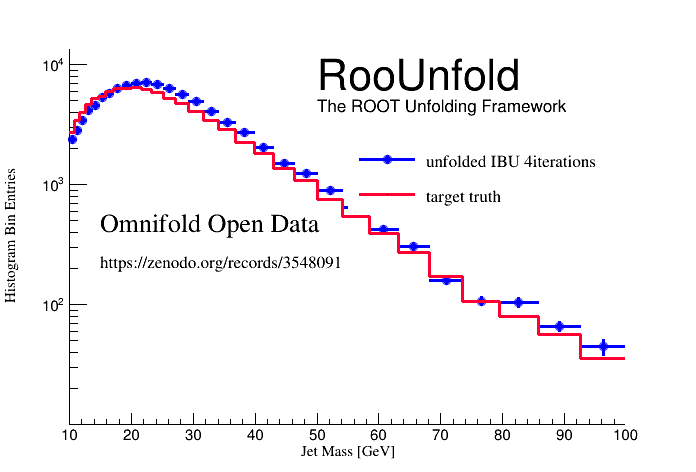

In [11]:
c2 = ROOT.TCanvas()
Hunfolded_level1.SetMarkerStyle(20)
Hunfolded_level1.SetMarkerColor(Hunfolded_level1.GetLineColor())
Hunfolded_level1.Draw()
targetHist.Draw("Hsame")
ROOT.gPad.SetLogy()
yaxis = Hunfolded_level1.GetYaxis()
yaxis.SetRangeUser(10,14000)
# Draw a white line over the axis bar
l = ROOT.TLine()
l.SetLineColor(ROOT.kWhite)
l.SetLineWidth(3)
l.DrawLine(10, 14000,100,14000)
l.DrawLine(100, 10,100,14000)

legend = ROOT.TLegend(.5,.55,.95,.7)
legend.AddEntry(Hunfolded_level1,"unfolded IBU 4iterations")
legend.AddEntry(targetHist,"target truth")
legend.SetBorderSize(0)
legend.SetTextFont(132)
legend.SetTextSize(.04)
legend.Draw()

# add logos
roounfold = ROOT.TText(50, 6100, "RooUnfold")
roounfold.SetTextFont(42)
roounfold.SetTextSize(.1)
roounfold.Draw()
roounfold2 = ROOT.TText(50, 4000, "The ROOT Unfolding Framework")
roounfold2.SetTextFont(42)
roounfold2.SetTextSize(.04)
roounfold2.Draw()

# and a title
tit1 = ROOT.TText(15, 400, 'Omnifold Open Data')
tit1.SetTextFont(132)
tit1.SetTextSize(.06)
tit1.Draw()
tit2 = ROOT.TText(15, 200, 'https://zenodo.org/records/3548091')
tit2.SetTextFont(132)
tit2.SetTextSize(.04)
tit2.Draw()
c2.Draw()

## Level 2: Professional

The `RooUnfoldSpec` class completely defines the unfolding problem in a single computationally efficient interface that unifies the battle tested unfolding algorithms from RooUnfold with the statistical modelling capability of RooFit

In [12]:
spec = ROOT.RooUnfoldSpec("unfold", "unfold",
                          truthHist,"obs_truth",
                          recoHist,"obs_reco",
                          responseHist,
                          0,
                          dataHist,
                          True,0.0005)

The parameters are as follows:
- `name` and `title` - as with any other root object
- `truth hist` and `truth observable` - This is because RooFit is used to define the range the unfolding is valid for
- `reco hist` and `reco observable` - as above
- `response hist` - we are unfolding after all
- `background hist` - optional
-  `includeUnderflowOverflow`, `errorThreshold` as described

The `RooUfoldSpec` can be used to provide the same unfolding operation as before, but provides a more correct handling of the propagation of uncertainties through the transformation.

In [13]:
unfolding = spec.makeFunc(ROOT.RooUnfolding.kBayes, 4)
#Hunfolded = unfolding.unfolding().Hunfold() This gives a null pointer...
# adding extra loop to fix
unfolded = unfolding.unfolding()

#additional systematics can be added using the `spec.registerSystematic` interface eg:
# spec.registerSystematic(ROOT.RooUnfoldSpec.kResponse, "Det_NP", response_up, response_down) 
# for now we just activate stat uncertainties at all levels
unfolded.IncludeSystematics(ROOT.RooUnfolding.kAll)


Hunfolded_level2 = truthHist.Clone()
Vunfolded = unfolded.Vunfold()
errs = unfolded.EunfoldV()
for b in range(1,Hunfolded_level2.GetNbinsX()):
    Hunfolded_level2.SetBinContent(b,Vunfolded[b])
    Hunfolded_level2.SetBinError(b,errs[b])
Hunfolded_level2.Print() # This should be a histogram.

TH1.Print Name  = truth, Entries= 100029, Total sum= 94622.8


Even if we are not using the systematic interface (shame on us) this interface gives us access to something even better...

### Bias Calculation

A quantity that represents this trade-off is the mean squared error (sum of bias squared and variance) averaged over the bins,

$$
\mathrm{MSE} = \frac{1}{M}\sum_{i=1}^{M}(V[\hat{\mu}_i]+b_i^2)
$$

Where the bias $b_i$ are a property of the estimators defined as the difference between estimator’s expectation and parameter’s true values,

$$
b_i = E[\hat{\mu}_i]-\mu_i
$$

and the variances $V[\hat{\mu}_i]$ (also written $\sigma^2_\hat{\mu_i}$) defined as the diagonal elements of the covariance matrix $\mathrm{cov}[\hat{\mu_i},\hat{\mu_j}]$.

Minimising the (bin-averaged) MSE as defined above is one of the core criteria for setting the regularisation parameter.

In [14]:
unfolded.CalculateBias(10000, spec.makeHistogram(truthHist))
bias_vec = unfolded.Vbias()
bias_err = unfolded.Ebias()
Hbias = truthHist.Clone()
for b in range(1,Hbias.GetNbinsX()+1):
    Hbias.SetBinContent(b,bias_vec[b])
    Hbias.SetBinError(b,bias_err[b])

### Coverage Probability
Another criterion that can be employed to set the degree of regularisation is based on the coverage probability of confidence intervals constructed for each bin of the true histogram. These can be taken as extending between plus and minus one standard deviation about the estimator, i.e., $[\hat{\mu}_i - \sigma_{\hat{\mu_i}} , \hat{\mu}_i + \sigma_{\hat{\mu_i}} ]$. Such an interval will contain the true value $\mu_i$ with a specified coverage probability and we take the average of these,

$$
P_\mathrm{cov} = \frac{1}{M}\sum_{i=1}^{M}P(\hat{\mu}_i - \sigma_{\hat{\mu_i}} < \mu_i< \hat{\mu}_i + \sigma_{\hat{\mu_i}} | \vec{\mu})
$$

as a criterion that can be used to choose the regularisation parameter. For the unregularised estimators $(\tau\rightarrow 0)$, $P_\mathrm{cov}$ tends towards the nominal coverage for a confidence interval of plus-or-minus one standard deviation about the maximum-likelihood estimator (assuming it is Gaussian distributed), i.e., $P_\mathrm{nom} = 68.3\%$. As the amount of regularisation is increased, the standard deviations $\sigma_\hat{μ_i}$ decrease, and thus the coverage probability also decreases. 

In [15]:
coverage_vec = unfolded.CoverageProbV()
Hcov = truthHist.Clone()
for b in range(1,Hcov.GetNbinsX()+1):
    Hcov.SetBinContent(b,coverage_vec[b])
    Hcov.SetBinError(b,0)

Cool! so how does that all look?

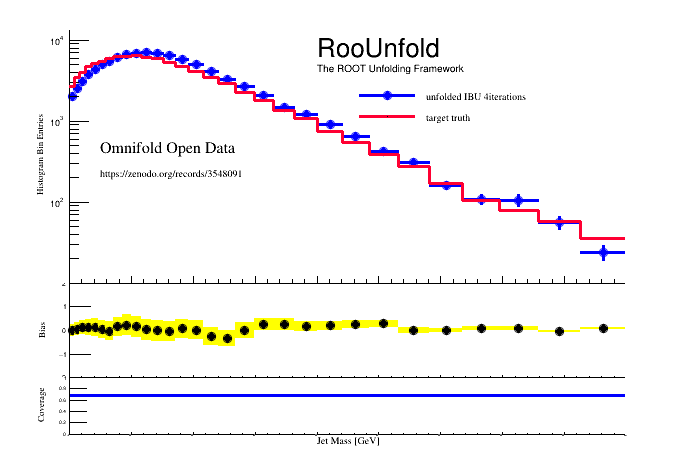

In [16]:
c3 = ROOT.TCanvas()
# Upper histogram plot is pad1
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.4, 1, 1.0)
pad1.SetBottomMargin(0)  # joins upper and lower plot
pad1.Draw()
# Lower ratio plot is pad2
c3.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.2, 1, 0.4)
pad2.SetTopMargin(0)  # joins upper and lower plot
pad2.SetBottomMargin(0)
pad2.Draw()
c3.cd()  # returns to main canvas before defining pad3
pad3 = ROOT.TPad("pad3", "pad2", 0, 0.05, 1, 0.2)
pad3.SetTopMargin(0)  # joins upper and lower plot
pad3.SetBottomMargin(0.2)
pad3.Draw()


pad1.cd()
Hunfolded_level2.SetMarkerStyle(20)
Hunfolded_level2.SetMarkerColor(Hunfolded_level1.GetLineColor())
Hunfolded_level2.Draw()
targetHist.Draw("Hsame")
ROOT.gPad.SetLogy()
yaxis = Hunfolded_level2.GetYaxis()
yaxis.SetRangeUser(10,14000)
yaxis.SetTitleOffset(.75)
# Draw a white line over the axis bar
l = ROOT.TLine()
l.SetLineColor(ROOT.kWhite)
l.SetLineWidth(3)
l.DrawLine(10, 14000,100,14000)
l.DrawLine(100, 10,100,14000)

legend = ROOT.TLegend(.5,.55,.95,.7)
legend.AddEntry(Hunfolded_level1,"unfolded IBU 4iterations")
legend.AddEntry(targetHist,"target truth")
legend.SetBorderSize(0)
legend.SetTextFont(132)
legend.SetTextSize(.04)
legend.Draw()

# add logos
roounfold = ROOT.TText(50, 6100, "RooUnfold")
roounfold.SetTextFont(42)
roounfold.SetTextSize(.1)
roounfold.Draw()
roounfold2 = ROOT.TText(50, 4000, "The ROOT Unfolding Framework")
roounfold2.SetTextFont(42)
roounfold2.SetTextSize(.04)
roounfold2.Draw()

# and a title
tit1 = ROOT.TText(15, 400, 'Omnifold Open Data')
tit1.SetTextFont(132)
tit1.SetTextSize(.06)
tit1.Draw()
tit2 = ROOT.TText(15, 200, 'https://zenodo.org/records/3548091')
tit2.SetTextFont(132)
tit2.SetTextSize(.04)
tit2.Draw()

pad2.cd()
Hbias.SetFillColor(ROOT.kYellow)
Hbias.SetMarkerStyle(20)
Hbias.Draw("E2")
l.DrawLine(100,-2,100,2)
y_bias = Hbias.GetYaxis()
y_bias.SetNdivisions(5)
y_bias.SetRangeUser(-2,2)
y_bias.SetTitle("Bias")
y_bias.SetTitleSize(.1)
y_bias.SetLabelSize(.08)
y_bias.SetTitleOffset(.25)

pad3.cd()
Hcov.Draw()
l.DrawLine(100,0,100,1)
y_cov = Hcov.GetYaxis()
y_cov.SetNdivisions(5)
y_cov.SetRangeUser(0,1)
y_cov.SetTitle("Coverage")
y_cov.SetTitleSize(.14)
y_cov.SetLabelSize(.08)
y_cov.SetTitleOffset(.18)
x_cov = Hcov.GetXaxis()
x_cov.SetTitleSize(.15)
x_cov.SetTitleOffset(.4)
c3.Draw()

## Level 3: Bleeding edge

This needs some helper functions that are not merged into core repo yet.

In [17]:
!git clone https://gitlab.cern.ch:/cburgard/inlh-unfolding-example.git

fatal: destination path 'inlh-unfolding-example' already exists and is not an empty directory.


In [18]:
!mv inlh-unfolding-example inlh_unfolding_example

### In likelihood Unfolding

Remember right back at the begining we said that the maximum likelihood estimators for $\nu$ are $\mathbf{n}$ and thus can be taken as estimators for $\mu$,

$$
\boldsymbol{\widehat{\mu}}=R^{-1}(\mathbf{n}-\beta)
$$

Well we have RooUnfold hooked up to RooFit so why not fit it?!

This example uses the standard binned profile likelihood type construction as implemented in Histfactory or Combine to construct the likelihood definition.

In [19]:
import importlib  
inlhunfolding = importlib.import_module("inlh_unfolding_example")
from inlh_unfolding_example import unfold
histograms = {"reco_bkg":ROOT.TH1F("bkg","bkg",30,binning),
              "reco_sig":recoHist,
              "response":responseHist,
              "truth":truthHist}

config = {
        "settings" : {
        "include_systematics" : True,
        "prune_systematics_threshold" : 0,
        "prune_migration_threshold" : 0,
        },
    
        "channels": {
            "reco_SR" : {
                "variables" : [ "reco_x" ],
                "samples": {
                    "background" : {
                        "data": "reco_bkg",
                        "modifiers" :[]
                    },
                    "signal": {
                        "data": "reco_sig",
                        "modifiers" :[],
                        "unfolding" : {
                            "regularize" : {
                                "type":"tikhonov",
                                "strength":1.5,
                                "curvature":"ss"
                            },
                            "poi" : "xs",
                            "poitype":"cs",
                            "truth" : {
                                "data": "truth",
                                "modifiers" :[]
                            },
                            "migration": {
                                "data": "response",
                                "modifiers" :[]
                            }
                        }
                    }
                }
            }
        }
    }

model = unfold.build_model(config, histograms, {"reco_SR":dataHist})

with open("model.hs3.json","wt") as outfile:
    import json
    json.dump(model,outfile)

workspace = unfold.build_workspace(model)    
unfold.write_workspace(workspace,"inlhworkspace.root")

[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::reco_x
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::tau_signal
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_1
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_10
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_11
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_12
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_13
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_14
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_15
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::xs_bin_16
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace) importing RooRealVar::x

So now we have our likelihood, so we can just fit it!

In [20]:
mc = workspace.obj("unfolded_model")
data = workspace.data("reco_SR")
xrange = workspace.obj("reco_x")

In [21]:
workspace.loadSnapshot("default_values")
r1 = mc.fitTo(data, ROOT.RooFit.Save(), ROOT.RooFit.Hesse())
workspace.saveSnapshot("postfit",mc.GetParametersOfInterest())

True

[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(reco_SR_background_shapes_Int[reco_x]) using numeric integrator RooBinIntegrator to calculate Int(reco_x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(reco_SR_signal_bin_1_shapes_Int[reco_x]) using numeric integrator RooBinIntegrator to calculate Int(reco_x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(reco_SR_signal_bin_2_shapes_Int[reco_x]) using numeric integrator RooBinIntegrator to calculate Int(reco_x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(reco_SR_signal_bin_3_shapes_Int[reco_x]) using numeric integrator RooBinIntegrator to calculate Int(reco_x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(reco_SR_signal_bin_4_shapes_Int[reco_x]) using numeric integrator RooBinIntegrator to calculate Int(reco_x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(reco_SR_signal_bin_5_shapes_In

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       -518315.234 Edm =       7645.284669 NCalls =    185
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -518315.234
  Edm           : 7645.284669
  Internal parameters:	[    0.02000133357    0.02000133357    0.02000133357    0.02000133357    0.02000133357    0.02000133357    0.02000133357    0.02000133357    0.02000133357    0.02000133357....     0.02000133357]	
  Internal gradient  :	[      5128.698174     -15606.63733     -27172.25906     -35675.27148     -42947.43823     -46012.50582     -46924.55252     -44489.32457     -39391.14533     -35931.88329....       175.0778542]	
  Internal covariance matrix:
[[  1.8103281e-05              0              0              0              0              0              0              0              0              0....               0]
 [              0  1.1443603e-06              0 

Super duper. You're brave and smart for making it this far. Well done. You deserve a treat. How about a lovely beautiful plot? wouldn't that be refreshing after all your hard work?

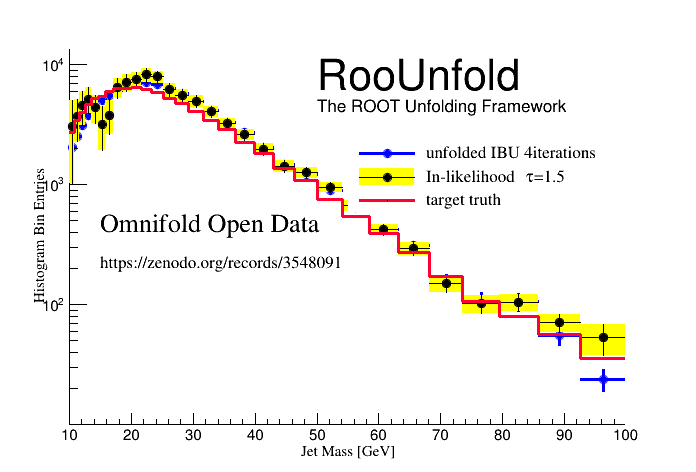

In [22]:
c4 = ROOT.TCanvas()
Hunfolded_level2.SetMarkerStyle(20)
Hunfolded_level2.SetMarkerColor(Hunfolded_level1.GetLineColor())
Hunfolded_level2.Draw()
workspace.loadSnapshot("postfit")
Hunfolded_level3 = unfold.get_unfolded_histogram(workspace,truthHist,"xs_bin_{:d}")
Hunfolded_level3.SetFillColor(ROOT.kYellow)
Hunfolded_level3.Draw("E2same")
Hunfolded_level3.SetMarkerStyle(20)
Hunfolded_level3.SetLineWidth(1)
Hunfolded_level3.SetLineColor(1)
Hunfolded_level3.Draw("same")

targetHist.Draw("Hsame")
ROOT.gPad.SetLogy()
yaxis = Hunfolded_level2.GetYaxis()
yaxis.SetRangeUser(10,14000)
# Draw a white line over the axis bar
l = ROOT.TLine()
l.SetLineColor(ROOT.kWhite)
l.SetLineWidth(3)
l.DrawLine(10, 14000,100,14000)
l.DrawLine(100, 10,100,14000)

legend = ROOT.TLegend(.5,.55,.95,.7)
legend.AddEntry(Hunfolded_level2,"unfolded IBU 4iterations")
legend.AddEntry(Hunfolded_level3,"In-likelihood #tau=1.5")
legend.AddEntry(targetHist,"target truth")
legend.SetBorderSize(0)
legend.SetTextFont(132)
legend.SetTextSize(.04)
legend.Draw()

# add logos
roounfold = ROOT.TText(50, 6100, "RooUnfold")
roounfold.SetTextFont(42)
roounfold.SetTextSize(.1)
roounfold.Draw()
roounfold2 = ROOT.TText(50, 4000, "The ROOT Unfolding Framework")
roounfold2.SetTextFont(42)
roounfold2.SetTextSize(.04)
roounfold2.Draw()

# and a title
tit1 = ROOT.TText(15, 400, 'Omnifold Open Data')
tit1.SetTextFont(132)
tit1.SetTextSize(.06)
tit1.Draw()
tit2 = ROOT.TText(15, 200, 'https://zenodo.org/records/3548091')
tit2.SetTextFont(132)
tit2.SetTextSize(.04)
tit2.Draw()
c4.Draw()